In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers import AveragePooling2D, Conv2D, MaxPooling2D, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
# import math
from sklearn.metrics import accuracy_score, precision_score, recall_score

/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
tf.__version__

'2.0.0'

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [4]:
batch_size = 64
num_classes = 10
num_epochs = 145

In [5]:
# Data preprocessing and cleaning:
# input image dimensions
img_rows, img_cols = 32, 32

# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [6]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

print("\n'input_shape' which will be used = {0}\n".format(input_shape))


'input_shape' which will be used = (32, 32, 3)



In [7]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [8]:
# convert class vectors/target to binary class matrices or one-hot encoded values-
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [9]:
print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train.shape = {1}".format(X_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test.shape = {1}".format(X_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (50000, 32, 32, 3), y_train.shape = (50000, 10)
X_test.shape = (10000, 32, 32, 3), y_test.shape = (10000, 10)


### Prepare CIFAR10 dataset for _GradientTape_ training:

In [10]:
# Create training and testing datasets-
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = batch_size, drop_remainder = False)

In [12]:
test_dataset = test_dataset.batch(batch_size=batch_size, drop_remainder=False)

In [13]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.CategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam(lr = 0.0003)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

In [14]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')

In [16]:
def pruned_nn():
# def pruned_nn(pruning_params_conv, pruning_params_fc):
    """
    Function to define the architecture of a convolutional neural network
    model following VGG-19 architecture for CIFAR-10 dataset.
    
    Vgg-19 architecture-
    64, 64, pool                 -- convolutional layers
    128, 128, pool               -- convolutional layers
    256, 256, 256, 256, max-pool -- convolutional layers
    512, 512, 512, 512, max-pool -- convolutional layers
    512, 512, 512, 512, avg-pool -- convolutional layers
    10                           -- fully connected layers
    
    Output: Returns designed and compiled convolutional neural network model
    """

    
    l = tf.keras.layers
    
    model = Sequential()
    
    model.add(
    Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)
        )
    )
    
    model.add(
    Conv2D(
            filters = 64, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 128, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 256, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    model.add(
    Conv2D(
            filters = 512, kernel_size = (3, 3),
            activation='relu', kernel_initializer = tf.initializers.GlorotUniform(),
            strides = (1, 1), padding = 'same'
        )
    )
    
    
    model.add(
    AveragePooling2D(
        pool_size=(2, 2), strides=(2, 2)
    )
    )
    
    
    '''
    model.add(
        MaxPooling2D(
            pool_size = (2, 2),
            strides = (2, 2)
        )
    )
    '''
    
    model.add(Flatten())
    
    
    model.add(
    Dense(
            units = 256, activation='relu'
        )
    )
    
    model.add(
    Dense(
            units = 256, activation='relu'
        )
    )
    
    '''
    model.add(
    Dense(
            units = 1000, activation='relu'
        )
    )
    '''
    
    model.add(
    Dense(
            units = 10, activation='softmax'
        )
    )
    
    
    # Compile pruned CNN-
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        # optimizer='adam',
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy']
    )
    
    return model

In [25]:
# Add a pruning step callback to peg the pruning step to the optimizer's
# step. Also add a callback to add pruning summaries to tensorboard
callback = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

In [17]:
# Initialize a CNN model-
orig_model = pruned_nn()

In [18]:
# Get CNN model summary-
orig_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         2

In [ ]:
# Train CNN using early stopping callback-
history = orig_model.fit(
        x = X_train, y = y_train,
        batch_size = batch_size,
        epochs = num_epochs,
        verbose = 1,
        # callbacks = callback,
        validation_data = (X_test, y_test),
        shuffle = True
    )
    

Train on 50000 samples, validate on 10000 samples
Epoch 1/145
40832/50000 [=======================>......] - ETA: 2:41 - loss: 2.3031 - accuracy: 0.0975

In [34]:
print("\nTraining completed of VGG-19 CNN on CIFAR-10 dataset\n")


Training completed of VGG-19 CNN on CIFAR-10 dataset



In [ ]:
history.history.keys()

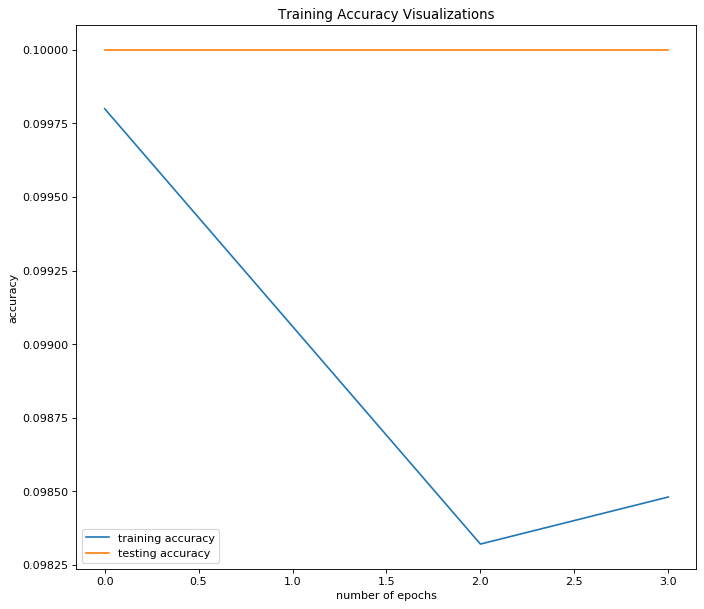

In [35]:
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'testing accuracy')

plt.title("Training Accuracy Visualizations")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend(loc = 'best')
plt.show()

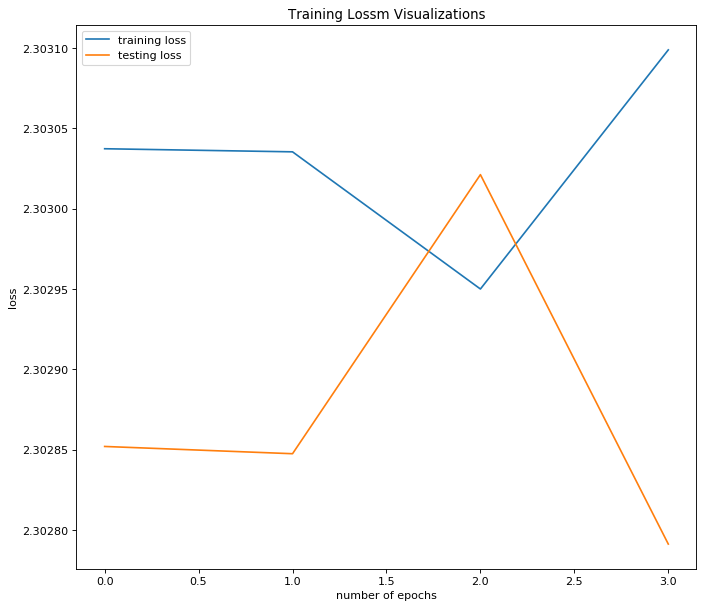

In [36]:
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'testing loss')

plt.title("Training Lossm Visualizations")
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.show()